# SDND Project 3 - Traffic Sign Recognition Classifier

## 0. Load the Data

In [1]:
import pickle

training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## 1. Dataset Summary

In [2]:
# -- Number of samples -- #
n_train = len(X_train)   
n_valid = len(X_valid)   
n_test = len(X_test)     

# -- Shape of a traffic sign image -- # 
image_shape = X_train[0].shape        

# -- Number of classes -- #
n_classes = len(set(y_train)) 

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of Dataset - TBA

7


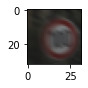

In [3]:
import matplotlib.pyplot as plt
import random

%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

## 2. Model Architecture

### 2.1. Data pre-processing

In [39]:
from sklearn.utils import shuffle
import numpy as np
import cv2

# -- 1. Shuffle the datasets. -- # 
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

# -- 2. Normalize the datasets. -- # 
tst1 = (X_train[0] - 128) / 128
# tst1 = X_train[0] / 255.0
print(tst1)
cv2.imshow('tst1', tst1)
cv2.waitKey(0)
cv2.destroyAllWindows()

tst2 = tst1 * 128 + 128
tst2 = np.uint8(tst2)

cv2.imshow('tst2', tst2)
cv2.waitKey(0)
cv2.destroyAllWindows()

def Normalize_Dataset(dataset):
    
    normalized = []
    
    for img in dataset:
        
        img = (img - 128) / 128
        normalized.append(img)
    
    return normalized

train_nm = Normalize_Dataset(X_train)
print(train_nm[0])

[[[1.296875  1.2734375 1.28125  ]
  [1.296875  1.265625  1.28125  ]
  [1.3046875 1.2890625 1.296875 ]
  ...
  [1.25      1.234375  1.2421875]
  [1.25      1.2421875 1.25     ]
  [1.2734375 1.2421875 1.2578125]]

 [[1.3125    1.28125   1.28125  ]
  [1.3125    1.2890625 1.296875 ]
  [1.3125    1.296875  1.296875 ]
  ...
  [1.25      1.2421875 1.2421875]
  [1.2578125 1.25      1.25     ]
  [1.2578125 1.2421875 1.2578125]]

 [[1.3125    1.2890625 1.2890625]
  [1.3203125 1.3046875 1.3046875]
  [1.34375   1.328125  1.3125   ]
  ...
  [1.25      1.234375  1.234375 ]
  [1.2578125 1.2421875 1.2421875]
  [1.25      1.2421875 1.25     ]]

 ...

 [[1.3828125 1.3671875 1.328125 ]
  [1.375     1.359375  1.3203125]
  [1.3671875 1.3671875 1.359375 ]
  ...
  [1.3046875 1.28125   1.28125  ]
  [1.296875  1.28125   1.2890625]
  [1.3125    1.296875  1.296875 ]]

 [[1.3984375 1.390625  1.3359375]
  [1.3984375 1.3671875 1.3359375]
  [1.3515625 1.3359375 1.328125 ]
  ...
  [1.3046875 1.28125   1.28125  ]
  [1